# Project 1. Predicting Walmart Sales

## What is it?
Predicting the weekly sales of Walmart stores based on data from 45 different locations from 2010 to 2012.

## Why was it made?
What's interesting about this project is how none of the factors considered are directly related to store sales/performance, but rather the circumstances of the region in which the stores are located.  

### To that point, the factors considered include:
* The average air temperature in the region [F]
* The cost of fuel in the region [USD/gallon]
* That week's consumer price index [USD]
* The unemployment rate in the region [%]
* Whether a holiday occured in that week
#### Along with engineered factors:
* the month the week happened in
* the week's number within the month
* the week's number within the year
* the differences between the current week's circumstances and the previous week's

Information about which store the data came from was also provided in the dataset, which may help train the model to predict the sales fro that particular store. Though, if the goal was to create a model able to accurately predict sales based only on regional data, such information should be ignored, to improve the model's generalization abilities.

### Project structure
While the main goal was to predict the weekly sales of any store, a store classification model was also trained. As is, the section of the project are:
* Exploratory Data Analysis - considering the distribution of the factors, the correlations between them and judging their usability
* Engineering new date and change-related features, exploring trends, correlations
* Considering different dataset, model and preprocessing choices then testing them on function created in order to speed up experimentation
* Presenting results, judging performance, considering contributors, alternatives
* The classification problem


**To get straight to the point, the results will be presented first, with the development techniques and explorations afterwards**

### Usage:
1. Run the **[Code setup](#Code-setup)** cells to set up the libraries and data sources
2. Run the **[Development](#Development)** to prepare the results for exploration
3. Run the **[Results](#Results)** cells and explore the project results

### Code setup

In [84]:
import pandas as pd
import numpy as np

import plotly.express as px
import plotly
from plotly.subplots import make_subplots
import plotly.graph_objects as go

import matplotlib.pyplot as plt
import seaborn as sns

import pendulum

import os

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import median_absolute_error
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor

# classification
from sklearn.svm import SVC
from sklearn.metrics  import f1_score,accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay

from xgboost import XGBRegressor

In [6]:
# based dataset
df_path  = '../datasets/walmart_sales.csv'
df = pd.read_csv(df_path)

# dataset with engineered features
df_eng_path = '../datasets/walmart_sales_engineered.csv'
df_eng = pd.read_csv(df_eng_path)

# final / best performing dataset
# with additional information about week number, month AND data about the previous week
# AND the differences between the current and previous week 
df_week_prev_diff = df_eng[['weekly_sales', 'holiday_flag', 'temperature',
       'fuel_price', 'cpi', 'unemployment', 'week_number', 'month',
       'week_of_month', 'prev_temperature',
       'prev_fuel_price', 'prev_cpi', 'prev_unemployment', 'weekly_sales_diff',
       'temperature_diff', 'fuel_price_diff', 'cpi_diff', 'unemployment_diff',
       'prev_holiday_flag', 'holiday_flag_diff', 'prev_month',
       'prev_week_number', 'prev_week_of_month']]

## Results

### What's in the data?
Before considering training, it is important to explore the relations and distributions present within the data. For that purpose, we can look at the data manually, it's distribution shapes and the correlations between the factors.

As such, a sample of the dataset:

In [139]:
df.sample(5)

store       date  weekly_sales  holiday_flag  temperature  fuel_price  \
3212     23 2011-05-13    1254914.87             0        55.12       4.095   
2780     20 2011-04-22    2313861.81             0        52.56       3.892   
2382     17 2011-11-25    1225700.28             1        32.81       3.445   
5013     36 2010-04-02     435972.82             0        63.43       2.708   
1403     10 2012-04-27    1712987.56             0        80.11       4.088   

             cpi  unemployment  week_number  month  ...  prev_holiday_flag  \
3212  134.593000         4.781           19      5  ...                0.0   
2780  208.477940         7.287           16      4  ...                0.0   
2382  129.836400         6.617           47     11  ...                0.0   
5013  209.593866         8.464           13      4  ...                0.0   
1403  131.126667         7.382           17      4  ...                0.0   

      prev_month  prev_week_number  prev_week_of_month  weekly_sales_diff  \
3212         5.0                18                 2.0         -105006.26   
2780         4.0                15                 3.0          256455.48   
2382        11.0                46                 3.0          347975.97   
5013         3.0                12                 4.0           31534.31   
1403         4.0                16                 4.0          -64178.97   

      temperature_diff  fuel_price_diff  cpi_diff  unemployment_diff  \
3212              5.05            0.017  0.078633               0.00   
2780             -2.44            0.071  0.160659               0.00   
2382             -0.12           -0.044  0.009567               0.00   
5013              7.67           -0.003 -0.193228              -0.09   
1403             12.36           -0.023  0.009333               0.00   

      holiday_flag_diff  
3212                0.0  
2780                0.0  
2382                1.0  
5013                0.0  
1403                0.0  

[5 rows x 26 columns]

The data statistics:

In [141]:
df_noeng.describe().transpose()

count          mean            std         min         25%  \
store         6435.0  2.300000e+01      12.988182       1.000      12.000   
weekly_sales  6435.0  1.046965e+06  564366.622054  209986.250  553350.105   
holiday_flag  6435.0  6.993007e-02       0.255049       0.000       0.000   
temperature   6435.0  6.066378e+01      18.444933      -2.060      47.460   
fuel_price    6435.0  3.358607e+00       0.459020       2.472       2.933   
cpi           6435.0  1.715784e+02      39.356712     126.064     131.735   
unemployment  6435.0  7.999151e+00       1.875885       3.879       6.891   

                        50%           75%           max  
store             23.000000  3.400000e+01  4.500000e+01  
weekly_sales  960746.040000  1.420159e+06  3.818686e+06  
holiday_flag       0.000000  0.000000e+00  1.000000e+00  
temperature       62.670000  7.494000e+01  1.001400e+02  
fuel_price         3.445000  3.735000e+00  4.468000e+00  
cpi              182.616521  2.127433e+02  2.272328e+02  
unemployment       7.874000  8.622000e+00  1.431300e+01

And the data distributions plots:

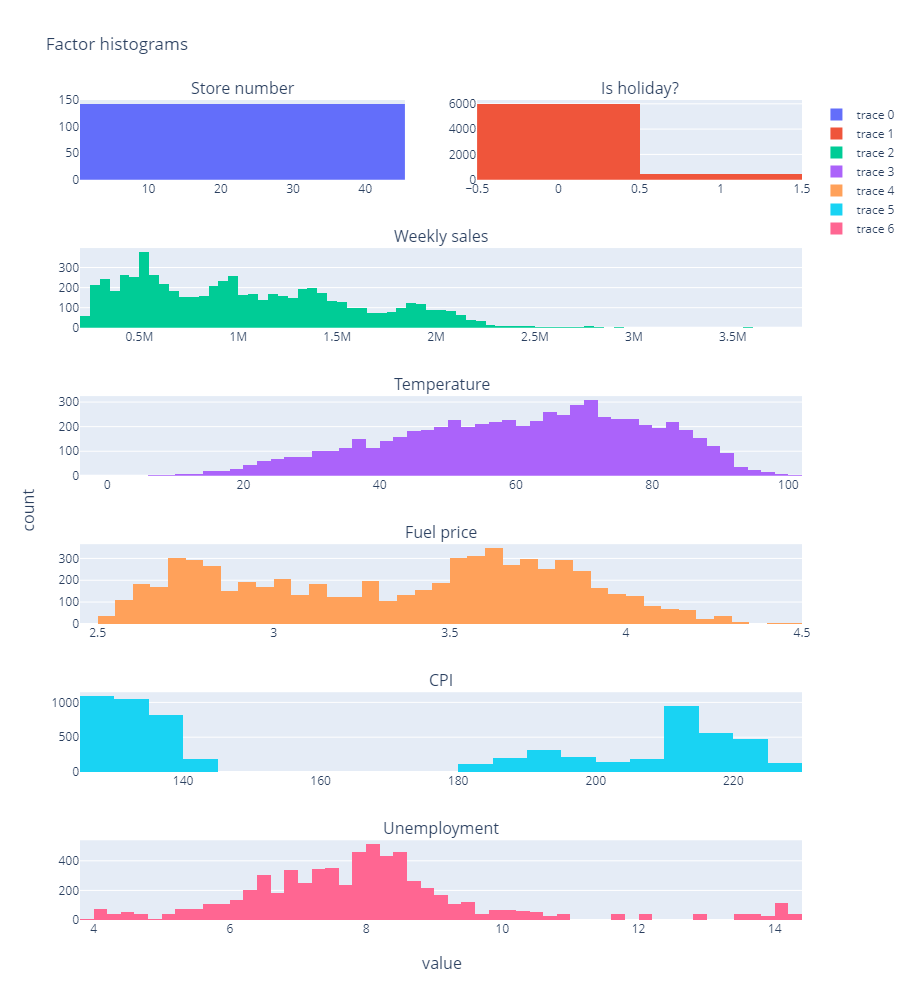

In [143]:
hist_fig = make_subplots(rows = 6, cols = 2,
                        subplot_titles=("Store number", "Is holiday?",
                                        "Weekly sales",
                                        "Temperature",
                                        "Fuel price",
                                        "CPI",
                                        "Unemployment"),
                        specs = [
                            [{}, {}],
                            [{"colspan": 2}, None],
                            [{"colspan": 2}, None],
                            [{"colspan": 2}, None],
                            [{"colspan": 2}, None],
                            [{"colspan": 2}, None],
                        ],
                         x_title = 'value',
                         y_title = 'count'
                        )
hist_fig.add_trace(
    go.Histogram(x=df['store']),
    row=1, col=1
)
hist_fig.add_trace(
    go.Histogram(x=df['holiday_flag']),
    row=1, col=2
)
hist_fig.add_trace(
    go.Histogram(x=df['weekly_sales']),
    row=2, col=1
)
hist_fig.add_trace(
    go.Histogram(x=df['temperature']),
    row=3, col=1
)
hist_fig.add_trace(
    go.Histogram(x=df['fuel_price']),
    row=4, col=1
)
hist_fig.add_trace(
    go.Histogram(x=df['cpi']),
    row=5, col=1
)
hist_fig.add_trace(
    go.Histogram(x=df['unemployment']),
    row=6, col=1
)

hist_fig.update_layout(
    title = "Factor histograms",
    # xaxis_title = "count",
    # yaxis_title = "value",
    height = 1000, width = 1200
)

# for i in range(1,5): 
#     fig['layout']['xaxis{}'.format(i)]['title']='Label X axis 1'
#     fig['layout']['yaxis{}'.format(i)]['title']='Label X axis 2'

# hist_fig.update_layout(autosize=False)

What conclusions can we reach from these distributions?
* The stores are represented evenly
* Unsurprisingly, the count of days with holidays is greatly smaller than of those without
* The range of weekly sales is quite vast, which might make the training more challenging, but also more robust
* The range of temperatures is also quite vast, which, if chosen as a factor may improve model's robustness
* The distribution of fuel prices may indicate either a sudden change in fuel prices at a point in time within the dataset or a difference between the stores regions
* A much clearer evidence of this may be visible in the Consumer Price Index
* The unemployment rate looks like a hetly distrubution, with a small amount of outliers

For a further exploration of the distribution, particularly for CPI and fuel price, see: **[Exploring the distributions further](#Exploring-the-distributions-further)** later in the notebook

Looking at the relationship matrix of available variables:

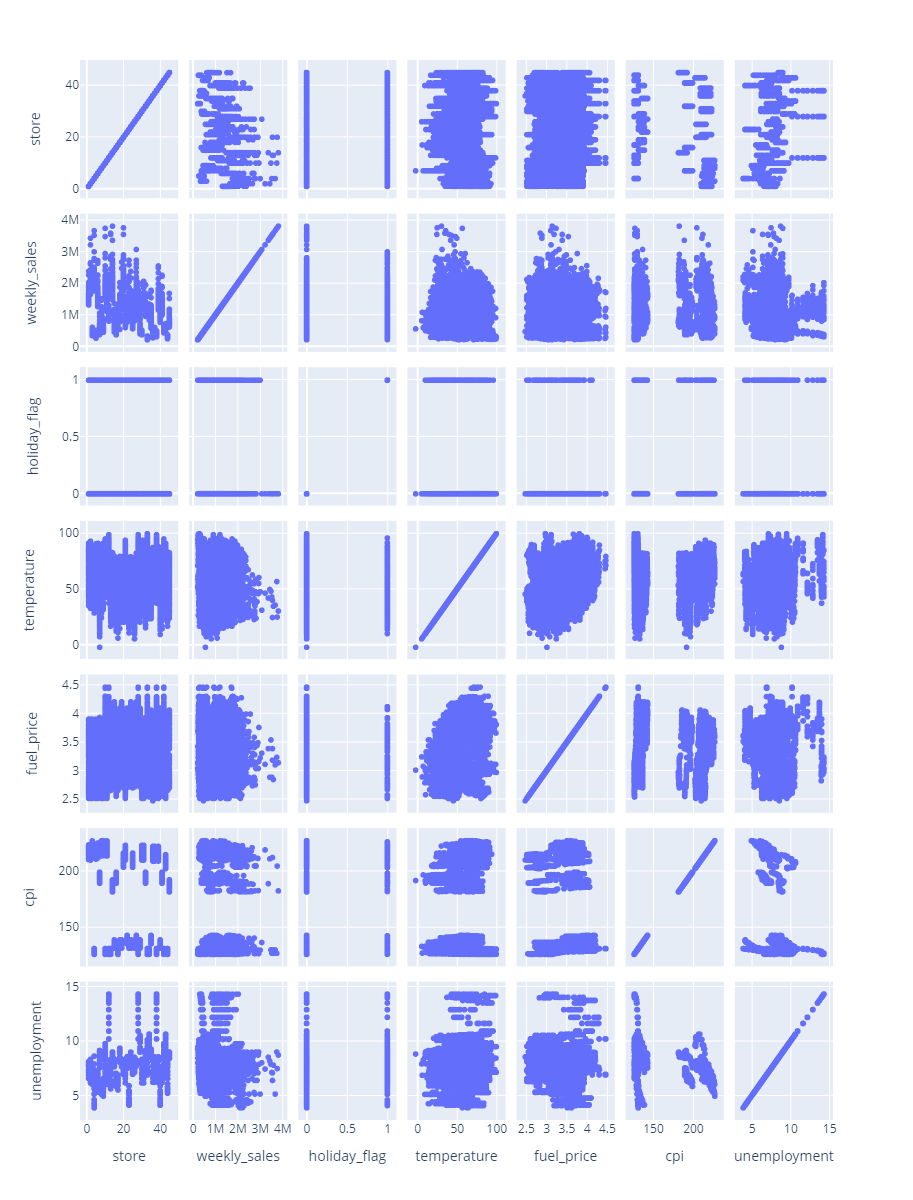

In [144]:
scatter_fig = px.scatter_matrix(df_noeng)
scatter_fig.update_layout(height = 1200, width = 1200)
scatter_fig.show()

* It's rather hard to make any substantial claims about any factor's relation to our predicted variable (weekly sales). No clear linear trends appear.  
* Still, the distribution plots appear more promising, with a healthy amount of variance and not a lot of extreme values for any of the factors.  
* The only possibly suspicious distribution is that of the consumer price index, with a clear distribution split, implying either a change in how it is calculated at some point in time, a sudden change in the US Dollar's value or some other event, which may not fare well for the model's generalizational skills.
* Nevertheless, it will be considrered as one of the factors to include in the prediction, as, how intuition suggests, it should strongly influence consumer spending habits.

### Feature engineering
To understand the exact operations taken in-depth, see **[Datatype cleanup, extra feature engineering](#Datatype-cleanup,-extra-feature-engineering)** further in the notebook.

As a repeat from the introduction, the features added were:
* the month the week happened in
* the week's number within the month
* the week's number within the year
* the differences between the current week's circumstances and the previous week's

With the rationale being:
* The number of the week within a month - may be related to typical salary payoff in the regions of the US. If many customers received their salary in a particualar week, they might spend more on that week or the week after. Conversely, if they haven't received a salary in a while, they might purchase less in general.
* The month - average customer spending could be related to the presence of big holidays within a month, the spending over the year may show cycling tendencies etc.
* The week of the year could show similar tendencies
* The value of the previous week's metrics and the difference between the current and the previous week's values might show tendencies such as whether a change in fuel price, the customer price index or a change in weather could affect customer behaviour

### Regression modelling / predicting weekly sales
To read up more about testing various model and dataset combinations, see **[Weekly sales regression modelling](Weekly-sales-regression-modelling)**.

In the end the model chosen was a XGBoost model with 2000 estimators and a learning rate of 0.01.

The dataset used for predicting included both the date-related factors as well as the previous week's values and the differences between the current week's and previous values, obviously excluding the difference between current week's sales, but including previous week's sales.

In [149]:
best_model_results

model           mae    median        r2        score  \
19  xgb_week_prev_diff  46130.886041  30040.87  0.984251  62588.36093   

    score_by_max  score_by_min  score_by_mean  score_by_median  score_by_std  
19          1.64         29.81           5.98             6.51         11.09

#### Measurement metrics

To judge the model, cross-validation across the whole dataset was conducted, as to prevent the accidental change of performance depending on the choice of testing datapoints.

With that, the **score column** represents the averaged mean absolute error cross-validated on the data set, in dollars.

To compare this results, let's look at the results of a baseline decision tree model trained on a dataset with no additional features, as well as the maximum, minimum, average, median and standard deviation values of the weekly sales recorded:

In [150]:
sales_df

max        min           avg     median        std model_type  \
0  3818686.45  209986.25  1.046965e+06  960746.04  564366.62  tree_base   

   mae_error  mae_by_max  mae_by_min  mae_by_avg  mae_by_median  mae_by_std  
0  420187.04        11.0       200.1       40.13          43.74       74.45

The baseline model achieved an error of around 420k dollars, which constitutes about 40% of the average sales values for all the stores. Not usable by any means.

In contrast, looking at the best performing model's results

A lowest mean absolute error of 43 thousand dollars could prove very useful. When looking at the averaged cross-validation score however, it raises to about 63 thousand, which still is only equal to about 6% of the mean of weekly sales and a measly 1,6% of the maximum recorded sales. Especially considering the premise of this project - how none of the factors directly relate to the store sales, with the closest in theory being the Consumer Price Index.

## Development

### Dataset exploration

#### A quick look

In [9]:
df.sample(5)

Store        Date  Weekly_Sales  Holiday_Flag  Temperature  Fuel_Price  \
5583     40  19-03-2010     894865.30             0        40.54       2.834   
4984     35  08-06-2012     873415.01             0        64.05       3.689   
3787     27  03-06-2011    2053708.01             0        74.17       4.069   
4044     29  12-11-2010     524450.70             0        44.42       2.961   
6395     45  27-01-2012     624081.64             0        37.93       3.567   

             CPI  Unemployment  
5583  131.824290         5.892  
4984  142.115810         8.876  
3787  138.769461         7.725  
4044  132.978323        10.524  
6395  189.516851         8.424

#### Are there any missing values that need to be handled?

In [8]:
df.isnull().sum()

Store           0
Date            0
Weekly_Sales    0
Holiday_Flag    0
Temperature     0
Fuel_Price      0
CPI             0
Unemployment    0
dtype: int64

#### Make column names uniform

In [10]:
df.columns = list(map(lambda col: col.lower().replace(' ', '_'), df.columns))

#### Explore the distribution of the factors within the dataset

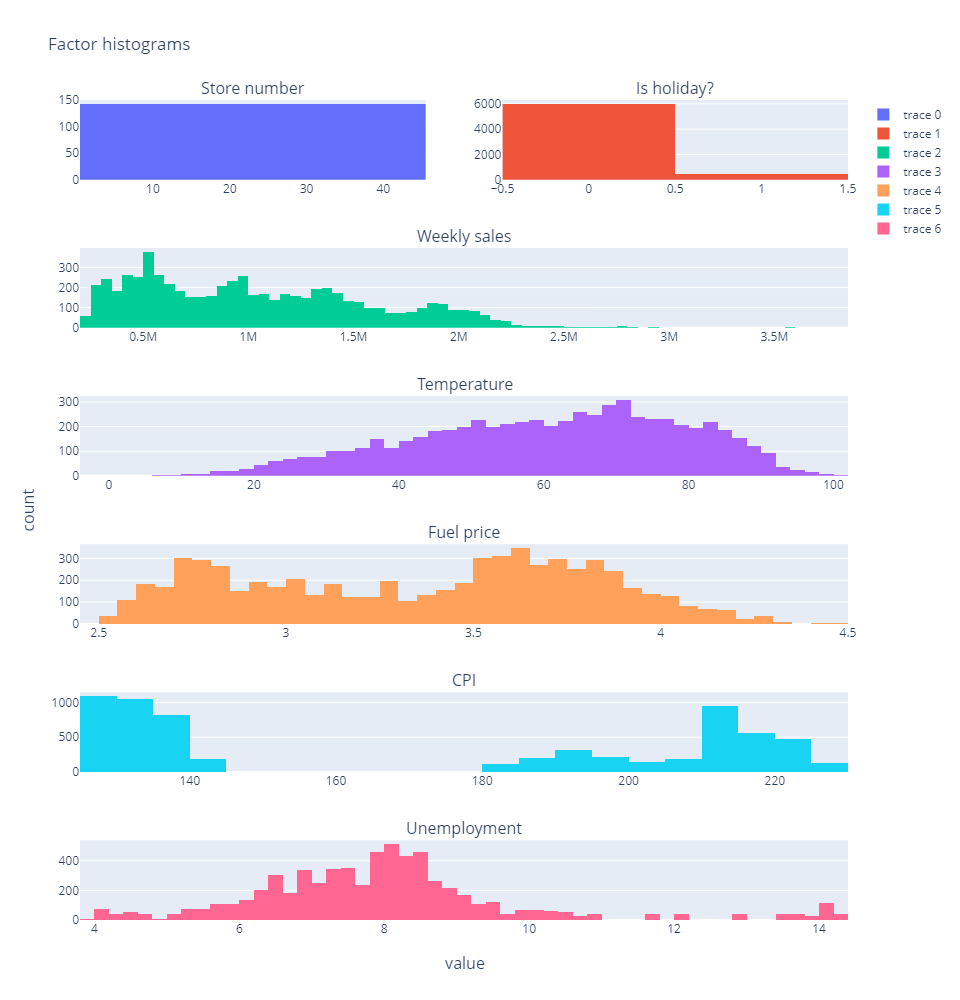

In [16]:
hist_fig = make_subplots(rows = 6, cols = 2,
                        subplot_titles=("Store number", "Is holiday?",
                                        "Weekly sales",
                                        "Temperature",
                                        "Fuel price",
                                        "CPI",
                                        "Unemployment"),
                        specs = [
                            [{}, {}],
                            [{"colspan": 2}, None],
                            [{"colspan": 2}, None],
                            [{"colspan": 2}, None],
                            [{"colspan": 2}, None],
                            [{"colspan": 2}, None],
                        ],
                         x_title = 'value',
                         y_title = 'count'
                        )
hist_fig.add_trace(
    go.Histogram(x=df['store']),
    row=1, col=1
)
hist_fig.add_trace(
    go.Histogram(x=df['holiday_flag']),
    row=1, col=2
)
hist_fig.add_trace(
    go.Histogram(x=df['weekly_sales']),
    row=2, col=1
)
hist_fig.add_trace(
    go.Histogram(x=df['temperature']),
    row=3, col=1
)
hist_fig.add_trace(
    go.Histogram(x=df['fuel_price']),
    row=4, col=1
)
hist_fig.add_trace(
    go.Histogram(x=df['cpi']),
    row=5, col=1
)
hist_fig.add_trace(
    go.Histogram(x=df['unemployment']),
    row=6, col=1
)

hist_fig.update_layout(
    title = "Factor histograms",
    # xaxis_title = "count",
    # yaxis_title = "value",
    height = 1000, width = 1200
)

# for i in range(1,5): 
#     fig['layout']['xaxis{}'.format(i)]['title']='Label X axis 1'
#     fig['layout']['yaxis{}'.format(i)]['title']='Label X axis 2'

# hist_fig.update_layout(autosize=False)

What conclusions can we reach from these distributions?
* The stores are represented evenly
* Unsurprisingly, the count of days with holidays is greatly smaller than of those without
* The range of weekly sales is quite vast, which might make the training more challenging, but also more robust
* The range of temperatures is also quite vast, which, if chosen as a factor may improve model's robustness
* The distribution of fuel prices may indicate either a sudden change in fuel prices at a point in time within the dataset or a difference between the stores regions
* A much clearer evidence of this may be visible in the Consumer Price Index
* The unemployment rate looks like a hetly distrubution, with a small amount of outliers

In [20]:
df.describe().transpose()

count          mean            std         min         25%  \
store         6435.0  2.300000e+01      12.988182       1.000      12.000   
weekly_sales  6435.0  1.046965e+06  564366.622054  209986.250  553350.105   
holiday_flag  6435.0  6.993007e-02       0.255049       0.000       0.000   
temperature   6435.0  6.066378e+01      18.444933      -2.060      47.460   
fuel_price    6435.0  3.358607e+00       0.459020       2.472       2.933   
cpi           6435.0  1.715784e+02      39.356712     126.064     131.735   
unemployment  6435.0  7.999151e+00       1.875885       3.879       6.891   

                        50%           75%           max  
store             23.000000  3.400000e+01  4.500000e+01  
weekly_sales  960746.040000  1.420159e+06  3.818686e+06  
holiday_flag       0.000000  0.000000e+00  1.000000e+00  
temperature       62.670000  7.494000e+01  1.001400e+02  
fuel_price         3.445000  3.735000e+00  4.468000e+00  
cpi              182.616521  2.127433e+02  2.272328e+02  
unemployment       7.874000  8.622000e+00  1.431300e+01

#### Exploring the distributions further
Looking at the source of the split in fuel price and CPI distrubutions

In [37]:
df_by_date = df.groupby(by=['date'], as_index='False').agg(date = ('date', 'first'), fuel_price = ('fuel_price', 'mean'),
                                                          cpi = ('cpi', 'mean'), unemployment = ('unemployment', 'mean'),
                                                          weekly_sales = ('weekly_sales', 'mean'))

In [32]:
df_by_date.columns

Index(['date', 'fuel_price', 'cpi'], dtype='object')

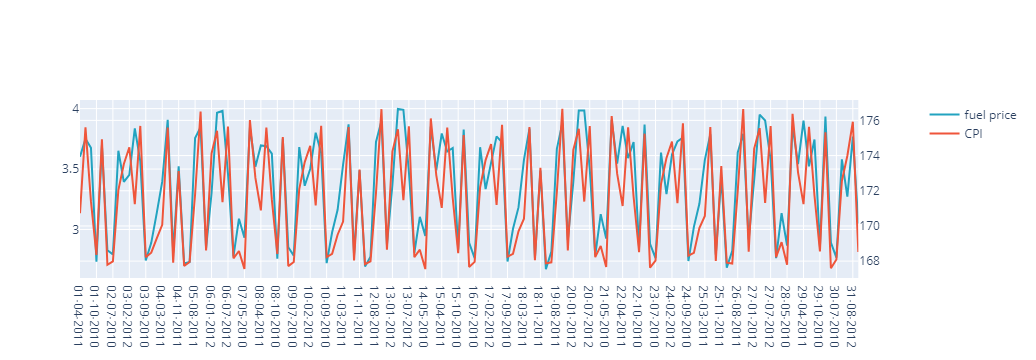

In [50]:
price_date_fig = make_subplots(specs=[[{"secondary_y": True}]])
price_trace = go.Line(
    x=df_by_date['date'],
    y=df_by_date['fuel_price'],
    name = 'fuel price',
    marker = dict(color='rgb(34,163,192)')
)
cpi_trace = go.Line(
    x=df_by_date['date'],
    y=df_by_date['cpi'],
    name = 'CPI',
    yaxis = 'y2'
)
price_date_fig.add_trace(price_trace)
price_date_fig.add_trace(cpi_trace, secondary_y=True)
price_date_fig.show()

There appears to be a very cyclic behaviour of both fuel price and CPI (averaged between stores) with not many  which might explain the distribution split. Before making any conclusions, a look at at the relation between these factors and the store shoud be taken.

In [44]:
df_by_store = df.groupby(by=['store'], as_index='False').agg(store = ('store', 'first'), fuel_price = ('fuel_price', 'mean'),
                                                          cpi = ('cpi', 'mean'), unemployment = ('unemployment', 'mean'),
                                                          weekly_sales = ('weekly_sales', 'mean'))

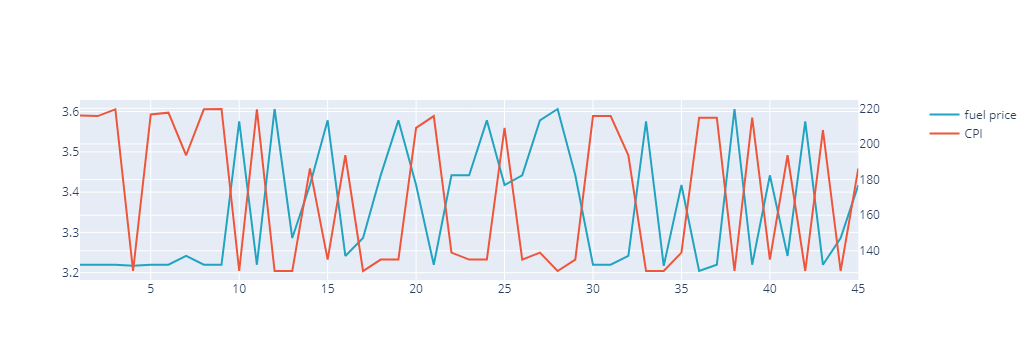

In [51]:
# px.line(df_by_store, x='store', y='fuel_price', title="Fuel price by store")
price_store_fig = make_subplots(specs=[[{"secondary_y": True}]])
price_trace = go.Line(
    x=df_by_store['store'],
    y=df_by_store['fuel_price'],
    name = 'fuel price',
    marker = dict(color='rgb(34,163,192)')
)
cpi_trace = go.Line(
    x=df_by_store['store'],
    y=df_by_store['cpi'],
    name = 'CPI',
    yaxis = 'y2'
)
price_store_fig.add_trace(price_trace)
price_store_fig.add_trace(cpi_trace, secondary_y=True)
price_store_fig.show()

There seems to be a reverse relation between fuel price and customer price index for many of the stores.

In [62]:
df_by_store[df_by_store['cpi'] < 150]['store'].unique().shape

(22,)

In [64]:
df_by_store[df_by_store['fuel_price'] < 3.4]['store'].unique().shape

(24,)

### Factor relationships

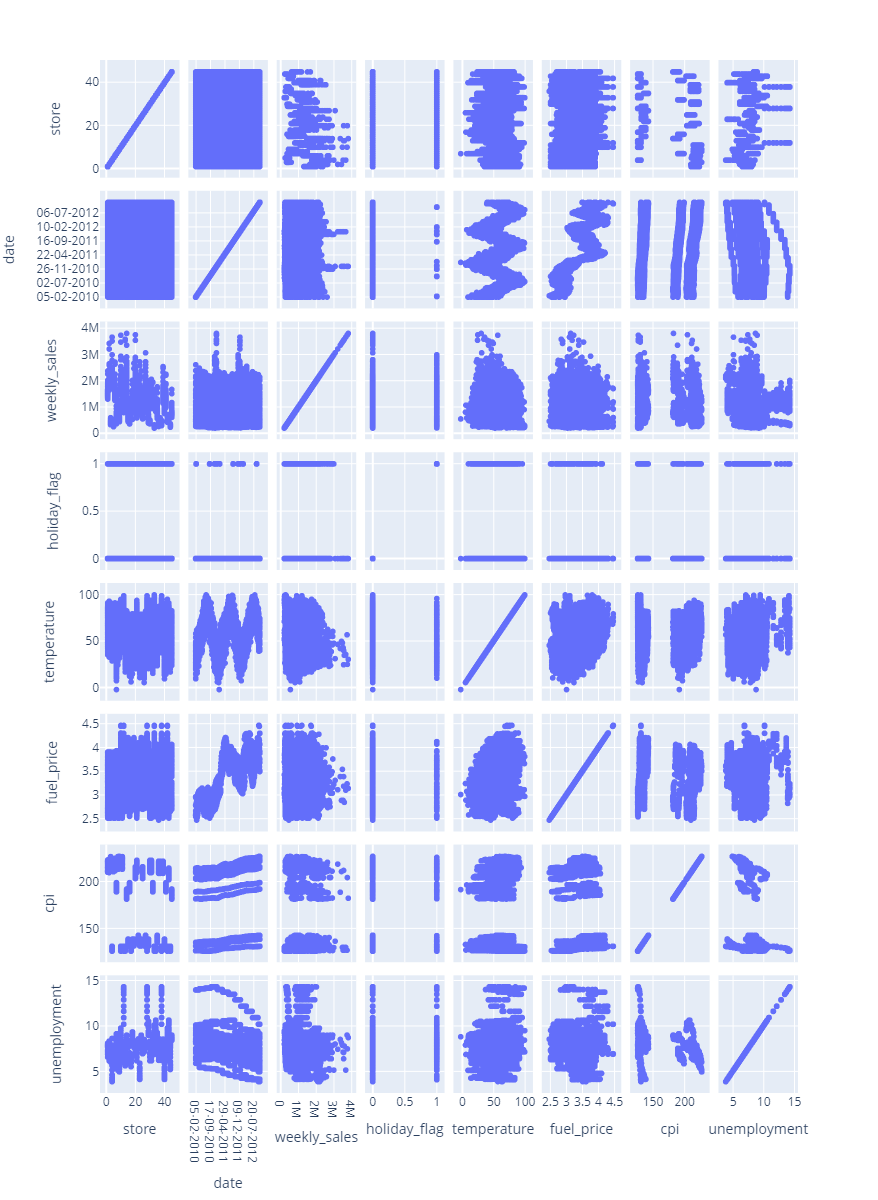

In [65]:
scatter_fig = px.scatter_matrix(df)
scatter_fig.update_layout(height = 1200, width = 1200)
scatter_fig.show()

* It's rather hard to make any substantial claims about any factor's relation to our predicted variable (weekly sales). No clear linear trends appear.  
* Still, the distribution plots appear more promising, with a healthy amount of variance and not a lot of extreme values for any of the factors.  
* The only possibly suspicious distribution is that of the consumer price index, with a clear distribution split, implying either a change in how it is calculated at some point in time, a sudden change in the US Dollar's value or some other event, which may not fare well for the model's generalizational skills.
* Nevertheless, it will be considrered as one of the factors to include in the prediction, as, how intuition suggests, it should strongly influence consumer spending habits.

### Datatype cleanup, extra feature engineering

#### Extra features - week number, month, week of month

In [66]:
df.dtypes
df['date'] = pd.to_datetime(df['date'], format="%d-%m-%Y")

df['week_number'] = df['date'].dt.isocalendar().week
df['month'] = df['date'].dt.month
df['week_of_month'] = df.apply(
    lambda row: pendulum.parse(row['date'].strftime('%Y-%m-%d')).week_of_month,
    axis=1
)

#### Extra features - previous week's values and value changes
Making sure to not overlap values from between stores

In [70]:
df['prev_weekly_sales'] = df.sort_values(['store','date']).groupby(['store'])['weekly_sales'].shift()
df['prev_temperature'] = df.sort_values(['store','date']).groupby(['store'])['temperature'].shift()
df['prev_fuel_price'] = df.sort_values(['store','date']).groupby(['store'])['fuel_price'].shift()
df['prev_cpi'] = df.sort_values(['store','date']).groupby(['store'])['cpi'].shift()
df['prev_unemployment'] = df.sort_values(['store','date']).groupby(['store'])['unemployment'].shift()
df['prev_holiday_flag'] = df.sort_values(['store','date']).groupby(['store'])['holiday_flag'].shift()
df['prev_month'] = df.sort_values(['store','date']).groupby(['store'])['month'].shift()
df['prev_week_number'] = df.sort_values(['store','date']).groupby(['store'])['week_number'].shift()
df['prev_week_of_month'] = df.sort_values(['store','date']).groupby(['store'])['week_of_month'].shift()

# fillna first values of type
df['prev_weekly_sales'] = df['prev_weekly_sales'].fillna(df['weekly_sales'])
df['prev_temperature'] = df['prev_temperature'].fillna(df['temperature'])
df['prev_fuel_price'] = df['prev_fuel_price'].fillna(df['fuel_price'])
df['prev_cpi'] = df['prev_cpi'].fillna(df['cpi'])
df['prev_unemployment'] = df['prev_unemployment'].fillna(df['unemployment'])
df['prev_holiday_flag'] = df['prev_holiday_flag'].fillna(df['holiday_flag'])
df['prev_month'] = df['prev_month'].fillna(df['month'])
df['prev_week_number'] = df['prev_week_number'].fillna(df['week_number'])
df['prev_week_of_month'] = df['prev_week_of_month'].fillna(df['week_of_month'])

Calculate differences from previous week to current

In [71]:
prev_cols = ['weekly_sales', 'temperature', 'fuel_price', 'cpi', 'unemployment', 'holiday_flag']
for col in prev_cols:
    df[f'{col}_diff'] = df[f'{col}'] - df[f'prev_{col}']

In [73]:
# scatter_2_cols = [f'prev_{col}' for col in prev_cols]
# scatter_fig_2 = px.scatter_matrix(df,
#                                  dimensions = scatter_2_cols)
# scatter_fig_2.update_layout(height = 1400, width = 1400)
# scatter_fig_2.show()

#### Date-related factors and weekly sales

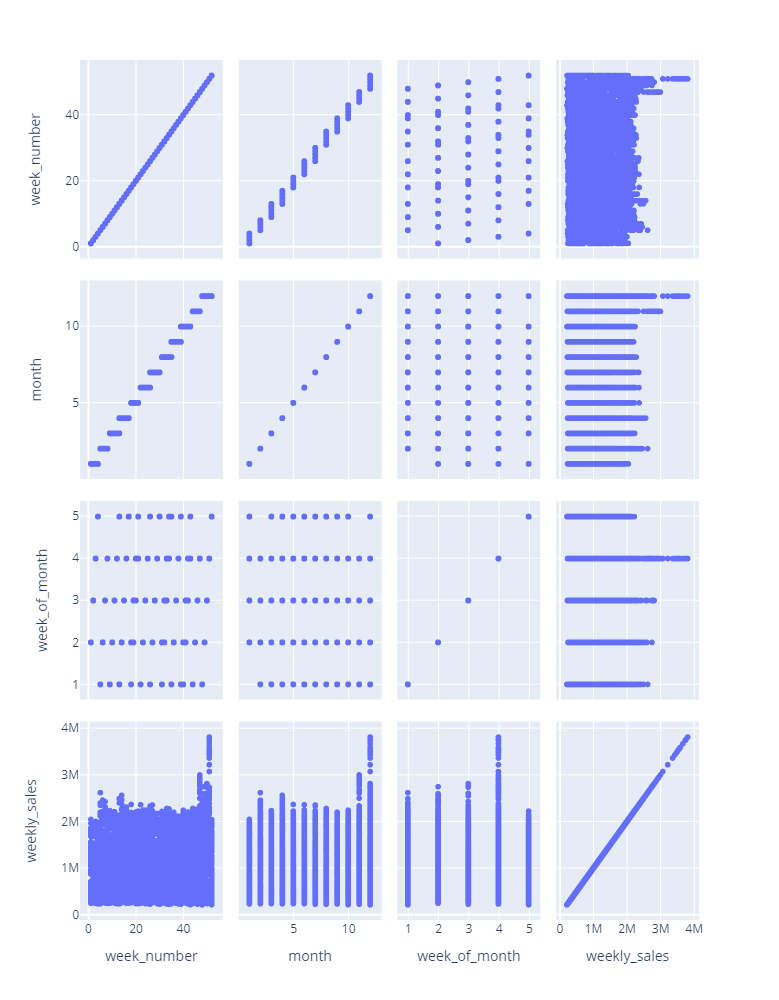

In [145]:
scatter_fig_week = px.scatter_matrix(df,
                                 dimensions = ['week_number', 'month', 'week_of_month', 'weekly_sales'])
scatter_fig_week.update_layout(height = 1000, width = 1000)
scatter_fig_week.show()

It would seem that typically week 4 is the big spender week in many of the stores. A similar rise can be ovserved in months 11 and 12 (november and december), which include both Thanksgiving Day and Christmas Holidays, which can drive up sales. Worth considering is also the following january fall in sales.

### Weekly sales regression modelling
With features prepared and their relationships explored, it may still be unclear how they might contribute to the prediction accuracy. Be it because of their vast variance, clear or unclear trends present in the data or uncaptured, indirect relations between the factors considered.

Even after that, there exists a vast range of techniques and model types that could perform differenly on supplied data, capturing different relations within it.

For those reasons, to make experimentation easier and faster, let's create a few helper functions, to allow for quick dataset, hypermarameter and model type choice swaps.

#### Baseline
Before diving further into exploring, let's establish the metrics against which we can judge model performance, for weekly sales, such a measure could be how the mean or median error of predictions compares to the minimum, maximum, mean and average weekly sale prices present in the dataset

In [78]:
max_sales = df['weekly_sales'].max()
min_sales = df['weekly_sales'].min()
avg_sales = df['weekly_sales'].mean()
median_sales = df['weekly_sales'].median()
std_sales = round(df['weekly_sales'].std(),2)
sales_data = {'max': [max_sales], 'min': [min_sales],
              'avg': [avg_sales], 'median': [median_sales],
             'std': [std_sales]}
sales_df = pd.DataFrame(sales_data)

In [79]:
sales_df

max        min           avg     median        std
0  3818686.45  209986.25  1.046965e+06  960746.04  564366.62

#### Baseline decision tree model
For a baseline performance, let's use a decision tree model with no hyperparameter tuning, only the base dataset features, no preprocessing and no cross-validation.

In [80]:
X_base = df[['holiday_flag', 'temperature',
       'fuel_price', 'cpi', 'unemployment', 'week_number', 'month',
       'week_of_month']]
y_base = df[['weekly_sales']]

X_base_train, X_base_test, y_base_train, y_base_test = train_test_split(
    X_base, y_base, shuffle=True, train_size=0.8)

tree_model_base = DecisionTreeRegressor()

tree_model_base.fit(X_base_train, y_base_train)

tree_base_preds = tree_model_base.predict(X_base_test)

tree_base_error = mean_absolute_error(y_base_test, tree_base_preds)
tree_base_error

420187.0377013727

In [82]:
sales_df['model_type'] = 'tree_base'
sales_df['mae_error'] = round(tree_base_error,2)
sales_df['mae_by_max'] = round(sales_df['mae_error'] * 100 / sales_df['max'],2)
sales_df['mae_by_min'] = round(sales_df['mae_error'] * 100 / sales_df['min'],2)
sales_df['mae_by_avg'] = round(sales_df['mae_error'] *100 / sales_df['avg'],2)
sales_df['mae_by_median'] = round(sales_df['mae_error'] * 100 / sales_df['median'],2)
sales_df['mae_by_std'] = round(sales_df['mae_error'] * 100 / sales_df['std'],2)

In [83]:
sales_df

max        min           avg     median        std model_type  \
0  3818686.45  209986.25  1.046965e+06  960746.04  564366.62  tree_base   

   mae_error  mae_by_max  mae_by_min  mae_by_avg  mae_by_median  mae_by_std  
0  420187.04        11.0       200.1       40.13          43.74       74.45

With a mean prediction error of ~420k USD, the scale of error is quite large, as it stands as 200% of the minimum sales value and about 40% of mean sales. Making the predictions extremely unpredictable.

### Uniform training function
The function will:
* take in model, dataset, parameters, training options
* scale / preprocess the data if specified
* train model
* cross-validate the model
* return results of mae, r2 score, median_error as a new row of dataframe collecting results from all types of models, datasets etc
* calculate the proportion of error to the max, min, average, median and std of weekly sales

In [ ]:
def preprocess_and_train_regression(model, dataset, target_col,
                                    standard_scale=True,
                                    model_name = None):
    print(f'model {model_name} started training')
    
    X = dataset.drop([target_col], axis=1)
    y = dataset[[target_col]]
    X_train, X_valid, y_train, y_valid = train_test_split(X, y.values.ravel(), shuffle=True, train_size=0.8)

    numerical_cols = [cname for cname in X_train.columns if X_train[cname].dtype in ['int64', 'float64',
                                                                                     'UInt32', 'int32']]
    # Preprocessing transformers
    numerical_transformer = StandardScaler()
    
    # combined preprocessor
    preprocessor = ColumnTransformer(
        transformers = [
            ('num', numerical_transformer, numerical_cols),
            # ('cat', categorical_transformer, categorical_cols)
        ]
    )
    
    # Bundle preprocessing and modeling code in a pipeline
    if standard_scale == True:
        train_pipeline = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('model', model)
        ])
    else:
        train_pipeline = Pipeline(steps=[
            ('model', model)
        ])
    
    # Preprocessing of training data, fit model 
    train_pipeline.fit(X_train, y_train.values.ravel())
    
    # Preprocessing of validation data, get predictions
    preds = train_pipeline.predict(X_valid)
    
    mae = mean_absolute_error(y_valid, preds)
    median = median_absolute_error(y_valid, preds)
    r2 = r2_score(y_valid, preds)

    # cross-validate and average the score
    scores = -1 * cross_val_score(train_pipeline,
                              X, y.values.ravel(),
                              cv=5,
                              scoring='neg_mean_absolute_error')
    score = scores.mean()

    print(f'model {model_name} trained, score: {score}')
    
    return mae, median, score, r2, model

In [115]:
def model_results_to_dataframe(mae, median, r2, score, model_name, results_df):
    new_row = {
        'model': model_name,
        'mae': mae,
        'median': median,
        'r2': r2,
        'score': score,
        'score_by_max': round(score * 100 / max_sales,2),
        'score_by_min': round(score * 100 / min_sales,2),
        'score_by_mean': round(score * 100 / avg_sales,2),
        'score_by_median': round(score * 100 / median_sales,2),
        'score_by_std': round(score * 100 / std_sales,2)
    }
    new_df = pd.DataFrame([new_row])
    results_df = pd.concat([results_df, new_df], ignore_index=True)
    
    return results_df

#### Define possible dataset combinations

In [88]:
# the base dataframe information the date
df_noeng = df[['store', 'weekly_sales', 'holiday_flag', 'temperature',
       'fuel_price', 'cpi', 'unemployment']]

# the base dataframe information the date and store
df_noeng_nostore = df[['weekly_sales', 'holiday_flag', 'temperature',
       'fuel_price', 'cpi', 'unemployment']]

# with additional information about week and month
df_week = df[['weekly_sales', 'holiday_flag', 'temperature',
       'fuel_price', 'cpi', 'unemployment', 'week_number', 'month',
       'week_of_month']]

# with additional information about week and month AND data about the previous week
df_week_prev = df[['weekly_sales', 'holiday_flag', 'temperature',
       'fuel_price', 'cpi', 'unemployment', 'week_number', 'month',
       'week_of_month', 'prev_weekly_sales', 'prev_temperature',
       'prev_fuel_price', 'prev_cpi', 'prev_unemployment', 'prev_month',
       'prev_week_number', 'prev_week_of_month']]

# with additional information about week and month AND data about the previous week AND the differences differences
df_week_prev_diff = df[['weekly_sales', 'holiday_flag', 'temperature',
       'fuel_price', 'cpi', 'unemployment', 'week_number', 'month',
       'week_of_month', 'prev_weekly_sales', 'prev_temperature',
       'prev_fuel_price', 'prev_cpi', 'prev_unemployment',
       'temperature_diff', 'fuel_price_diff', 'cpi_diff', 'unemployment_diff',
       'prev_holiday_flag', 'holiday_flag_diff', 'prev_month',
       'prev_week_number', 'prev_week_of_month']]

# with differences, without holiday and temperature - least directly related factors
df_week_prev_diff_no_holiday = df[['weekly_sales',
       'fuel_price', 'cpi', 'unemployment', 'week_number', 'month',
       'week_of_month', 'prev_weekly_sales',
       'prev_fuel_price', 'prev_cpi', 'prev_unemployment',
        'fuel_price_diff', 'cpi_diff', 'unemployment_diff',
        'prev_month',
       'prev_week_number', 'prev_week_of_month']]

df_week_prev_diff_store = df[['store', 'weekly_sales', 'holiday_flag', 'temperature',
       'fuel_price', 'cpi', 'unemployment', 'week_number', 'month',
       'week_of_month', 'prev_weekly_sales', 'prev_temperature',
       'prev_fuel_price', 'prev_cpi', 'prev_unemployment',
       'temperature_diff', 'fuel_price_diff', 'cpi_diff', 'unemployment_diff',
       'prev_holiday_flag', 'holiday_flag_diff', 'prev_month',
       'prev_week_number', 'prev_week_of_month']]

In [89]:
datasets = [df_noeng, df_noeng_nostore,
            df_week, df_week_prev,
            df_week_prev_diff, df_week_prev_diff_no_holiday,
            df_week_prev_diff_store]
dataset_names = ['noeng', 'noeng_nostore',
                 'week', 'week_prev',
                 'week_prev_diff', 'week_prev_diff_no_holiday',
                 'week_prev_diff_store']

### Decision Tree models
Let's try tuning tree models by setting the maximum leaf nodes, as setting the maximum depth, will stop only at that depth, whilst choosing a maximum number of leaf nodes will try to optimize for best results and potentially drop some branches and reach a further overall depth.

For baseline tree model performance, only the base dataset will be used.

In [90]:
def get_tree_mae(max_leaf_nodes, train_X, val_X, train_y, val_y):
    model = DecisionTreeRegressor(max_leaf_nodes = max_leaf_nodes)
    model.fit(train_X, train_y)
    preds_val = model.predict(val_X)
    mae = mean_absolute_error(val_y, preds_val)
    return mae

In [91]:
best_base_tree_mae = tree_base_error
for max_leaf_nodes in [5, 50, 200, 250, 350, 500, 1000, 1750, 2500, 5000]:
    leaf_mae = get_tree_mae(max_leaf_nodes, X_base_train, X_base_test, y_base_train, y_base_test)
    if leaf_mae < best_base_tree_mae:
        best_base_tree_mae = leaf_mae
    print(f'Max leaf nodes: {max_leaf_nodes}, MAE Error: {leaf_mae}')

Max leaf nodes: 5, MAE Error: 446519.9707997787
Max leaf nodes: 50, MAE Error: 379788.8059422502
Max leaf nodes: 200, MAE Error: 339112.3910169378
Max leaf nodes: 250, MAE Error: 343275.4648538555
Max leaf nodes: 350, MAE Error: 346387.7721077223
Max leaf nodes: 500, MAE Error: 358111.0463730722
Max leaf nodes: 1000, MAE Error: 389869.8236766568
Max leaf nodes: 1750, MAE Error: 414201.68577875226
Max leaf nodes: 2500, MAE Error: 419751.69282799336
Max leaf nodes: 5000, MAE Error: 420923.29227143235


#### Max leaf nodes set as 200

#### Quickly assess the datasets

In [92]:
def assess_sales_dataset_tree(input_df):
    input_X = input_df.drop(['weekly_sales'], axis=1)
    input_y = input_df[['weekly_sales']]
    X_train, X_test, y_train, y_test = train_test_split(input_X, input_y, shuffle=True, train_size=0.8)
    model = DecisionTreeRegressor(max_leaf_nodes = 200)
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    mae = mean_absolute_error(y_test, preds)
    return mae

In [93]:
best_tree_dataset_mae = df[['weekly_sales']].max().values[0]
for df_index, dataset in enumerate(datasets):
    df_mae = assess_sales_dataset_tree(dataset)
    if df_mae < best_tree_dataset_mae:
        best_tree_dataset_mae = df_mae
    print(f'df: {dataset_names[df_index]}, MAE Error: {df_mae}')

df: noeng, MAE Error: 84022.00806245643
df: noeng_nostore, MAE Error: 324937.1443830105
df: week, MAE Error: 353246.784979763
df: week_prev, MAE Error: 61710.66724940243
df: week_prev_diff, MAE Error: 65296.17533971916
df: week_prev_diff_no_holiday, MAE Error: 63421.775561149145
df: week_prev_diff_store, MAE Error: 61471.813149651076


### Clearly, using the previous week information yields the best results
* What's interesting is how the removal of the 'store' information, had terrible consequences. Perhaps it is unsurprising - information about which store you are considering will probably strongly influence the sales prediction, as can be seen in the weekly sales distribution, which has quite a large range.
* The question is - do we want to use this information, for most accurate results or do we want to ignore it, to make the model more general and applicable to any store not present in the dataset, but rather limiting ourselves to only data about the region such potential store would reside in.

### Be warned - data leakage danger
* To calculate the difference between previous week's sales and the current - you'd need current week's sales - which is why, it was important to remove this column from the datasets
* It might also be interesting to consider predicting without definitive weekly differences (as in being future-oriented) or with these values

### XGBoost
Taking in our best perfoming dataset and using it with a more mathematically complex model, let's test for hyperparameter combinations

In [94]:
X = df_week_prev.drop(['weekly_sales'], axis=1)
y = df_week_prev[['weekly_sales']]
X_train, X_test, y_train, y_test = train_test_split(X, y.values.ravel(), shuffle=True, train_size=0.8)

In [95]:
def get_xgb_mae(n_estimators, learning_rate, train_X, val_X, train_y, val_y, early_stopping_rounds = 5):
    model = XGBRegressor(n_estimators = n_estimators, learning_rate=learning_rate)
    model.fit(train_X, train_y,
             early_stopping_rounds=early_stopping_rounds,
             eval_set=[(val_X, val_y)],
             verbose=False)
    preds_val = model.predict(val_X)
    mae = mean_absolute_error(val_y, preds_val)
    return mae

In [97]:
best_xgb_mae = y_train.max()
for n_estimators in [100, 250, 500, 1000, 2000, 5000]:
    for learning_rate in [0.001, 0.01, 0.02, 0.05, 0.1]:
        xgb_mae = get_xgb_mae(n_estimators, learning_rate, X_train, X_test, y_train, y_test)
        if xgb_mae < best_xgb_mae:
            best_xgb_mae = xgb_mae
        print(f'n_estimators: {n_estimators}, learning_rate: {learning_rate}, MAE Error: {xgb_mae}')

C:\Users\User\Desktop\programowanie_web_etc\python_projects\ml_zoo\venv\lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



n_estimators: 100, learning_rate: 0.001, MAE Error: 428190.24355089356
n_estimators: 100, learning_rate: 0.01, MAE Error: 185510.11071872571


C:\Users\User\Desktop\programowanie_web_etc\python_projects\ml_zoo\venv\lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

C:\Users\User\Desktop\programowanie_web_etc\python_projects\ml_zoo\venv\lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



n_estimators: 100, learning_rate: 0.02, MAE Error: 89732.08037296036
n_estimators: 100, learning_rate: 0.05, MAE Error: 50389.364769327905


C:\Users\User\Desktop\programowanie_web_etc\python_projects\ml_zoo\venv\lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

C:\Users\User\Desktop\programowanie_web_etc\python_projects\ml_zoo\venv\lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



n_estimators: 100, learning_rate: 0.1, MAE Error: 45356.34379079255


C:\Users\User\Desktop\programowanie_web_etc\python_projects\ml_zoo\venv\lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



n_estimators: 250, learning_rate: 0.001, MAE Error: 370521.3963539239


C:\Users\User\Desktop\programowanie_web_etc\python_projects\ml_zoo\venv\lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



n_estimators: 250, learning_rate: 0.01, MAE Error: 71578.2587898213


C:\Users\User\Desktop\programowanie_web_etc\python_projects\ml_zoo\venv\lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



n_estimators: 250, learning_rate: 0.02, MAE Error: 50024.31217754468


C:\Users\User\Desktop\programowanie_web_etc\python_projects\ml_zoo\venv\lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



n_estimators: 250, learning_rate: 0.05, MAE Error: 44396.95356740482
n_estimators: 250, learning_rate: 0.1, MAE Error: 44121.89550359363


C:\Users\User\Desktop\programowanie_web_etc\python_projects\ml_zoo\venv\lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

C:\Users\User\Desktop\programowanie_web_etc\python_projects\ml_zoo\venv\lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



n_estimators: 500, learning_rate: 0.001, MAE Error: 292084.99215229216


C:\Users\User\Desktop\programowanie_web_etc\python_projects\ml_zoo\venv\lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



n_estimators: 500, learning_rate: 0.01, MAE Error: 50264.712916181044


C:\Users\User\Desktop\programowanie_web_etc\python_projects\ml_zoo\venv\lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



n_estimators: 500, learning_rate: 0.02, MAE Error: 44961.316956585084


C:\Users\User\Desktop\programowanie_web_etc\python_projects\ml_zoo\venv\lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



n_estimators: 500, learning_rate: 0.05, MAE Error: 43254.14182498058
n_estimators: 500, learning_rate: 0.1, MAE Error: 44121.89550359363


C:\Users\User\Desktop\programowanie_web_etc\python_projects\ml_zoo\venv\lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

C:\Users\User\Desktop\programowanie_web_etc\python_projects\ml_zoo\venv\lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



n_estimators: 1000, learning_rate: 0.001, MAE Error: 186231.52097513597


C:\Users\User\Desktop\programowanie_web_etc\python_projects\ml_zoo\venv\lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



n_estimators: 1000, learning_rate: 0.01, MAE Error: 45290.04597416473


C:\Users\User\Desktop\programowanie_web_etc\python_projects\ml_zoo\venv\lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



n_estimators: 1000, learning_rate: 0.02, MAE Error: 43993.42433177934


C:\Users\User\Desktop\programowanie_web_etc\python_projects\ml_zoo\venv\lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



n_estimators: 1000, learning_rate: 0.05, MAE Error: 43254.14182498058
n_estimators: 1000, learning_rate: 0.1, MAE Error: 44121.89550359363


C:\Users\User\Desktop\programowanie_web_etc\python_projects\ml_zoo\venv\lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

C:\Users\User\Desktop\programowanie_web_etc\python_projects\ml_zoo\venv\lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



n_estimators: 2000, learning_rate: 0.001, MAE Error: 90851.70342657343


C:\Users\User\Desktop\programowanie_web_etc\python_projects\ml_zoo\venv\lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



n_estimators: 2000, learning_rate: 0.01, MAE Error: 44408.71970231158


C:\Users\User\Desktop\programowanie_web_etc\python_projects\ml_zoo\venv\lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



n_estimators: 2000, learning_rate: 0.02, MAE Error: 43993.42433177934


C:\Users\User\Desktop\programowanie_web_etc\python_projects\ml_zoo\venv\lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



n_estimators: 2000, learning_rate: 0.05, MAE Error: 43254.14182498058
n_estimators: 2000, learning_rate: 0.1, MAE Error: 44121.89550359363


C:\Users\User\Desktop\programowanie_web_etc\python_projects\ml_zoo\venv\lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

C:\Users\User\Desktop\programowanie_web_etc\python_projects\ml_zoo\venv\lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



n_estimators: 5000, learning_rate: 0.001, MAE Error: 50267.50674048174


C:\Users\User\Desktop\programowanie_web_etc\python_projects\ml_zoo\venv\lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



n_estimators: 5000, learning_rate: 0.01, MAE Error: 44408.71970231158


C:\Users\User\Desktop\programowanie_web_etc\python_projects\ml_zoo\venv\lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



n_estimators: 5000, learning_rate: 0.02, MAE Error: 43993.42433177934


C:\Users\User\Desktop\programowanie_web_etc\python_projects\ml_zoo\venv\lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



n_estimators: 5000, learning_rate: 0.05, MAE Error: 43254.14182498058


C:\Users\User\Desktop\programowanie_web_etc\python_projects\ml_zoo\venv\lib\site-packages\xgboost\sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



n_estimators: 5000, learning_rate: 0.1, MAE Error: 44121.89550359363


#### Best XGB model: n_estimators = 2000, learning_rater = 0.01

### SVR, SGDRegressor and good ol' LinearRegression

In [99]:
from sklearn.svm import SVR
svr_model = SVR()
svr_model.fit(X_train, y_train)
svr_preds = svr_model.predict(X_test)
svr_mae = mean_absolute_error(svr_preds, y_test)
svr_mae

467934.9685618188

In [100]:
from sklearn.linear_model import LinearRegression
svr_model = LinearRegression()
svr_model.fit(X_train, y_train)
svr_preds = svr_model.predict(X_test)
svr_mae = mean_absolute_error(svr_preds, y_test)
svr_mae

87259.00427113059

In [101]:
from sklearn.linear_model import SGDRegressor
svr_model = SGDRegressor()
svr_model.fit(X_train, y_train)
svr_preds = svr_model.predict(X_test)
svr_mae = mean_absolute_error(svr_preds, y_test)
svr_mae

1.8835338791574834e+20

Interestlingly, the simplest LinearRegression model performed quite well, while a stochastic gradient regressor got completely lost.

### Using the uniform training function

#### prepare the models table

In [117]:
tree_model = DecisionTreeRegressor(max_leaf_nodes=200)
random_forest_model = RandomForestRegressor()
linear_model = LinearRegression()
xgb_model = XGBRegressor(n_estimators=2000, learning_rate=0.1)

models = [tree_model, random_forest_model, linear_model, xgb_model]
model_names = ['tree', 'random_forest', 'linear', 'xgb']

In [131]:
results_df = pd.DataFrame()
max_sales = df['weekly_sales'].max()
min_sales = df['weekly_sales'].min()
avg_sales = df['weekly_sales'].mean()
median_sales = df['weekly_sales'].median()
std_sales = round(df['weekly_sales'].std(),2)

In [132]:
for d_index, dataset in enumerate(datasets):
    for m_index, model in enumerate(models):
        model_name = f'{model_names[m_index]}_{dataset_names[d_index]}'
        mae, median, score, r2, model = preprocess_and_train_regression(model = model,
                                        dataset = dataset,
                                        target_col = 'weekly_sales',
                                        standard_scale=True,
                                        model_name = model_name
                                       )
        results_df = model_results_to_dataframe(mae, median, r2, score, model_name, results_df)


C:\Users\User\Desktop\programowanie_web_etc\python_projects\ml_zoo\venv\lib\site-packages\sklearn\base.py:1474: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\Users\User\Desktop\programowanie_web_etc\python_projects\ml_zoo\venv\lib\site-packages\sklearn\base.py:1474: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\Users\User\Desktop\programowanie_web_etc\python_projects\ml_zoo\venv\lib\site-packages\sklearn\base.py:1474: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\Users\User\Desktop\programowanie_web_etc\python_projects\ml_zoo\venv\lib\site-packages\sklearn\base.py:1474: DataConversionWarning:

A column-vector y was passed when a 1d array was expected

In [133]:
# dataset_names

In [130]:
# mae, median, score, r2, model = preprocess_and_train_regression(model = xgb_model,
#                                 dataset = df_week_prev,
#                                 target_col = 'weekly_sales',
#                                 standard_scale=True,
#                                 model_name = 'xgb_week_prev'
#                                )

In [129]:
# results_df = model_results_to_dataframe(mae, median, r2, score, 'xgb_week_prev', results_df)

In [134]:
results_df

model            mae         median  \
0                                tree_noeng   84706.757542   43572.073243   
1                       random_forest_noeng   77758.534430   38878.426400   
2                              linear_noeng  434934.024676  394571.930030   
3                                 xgb_noeng   68052.065504   38991.072500   
4                        tree_noeng_nostore  335014.412405  233808.993714   
5               random_forest_noeng_nostore  374374.137288  255421.868500   
6                      linear_noeng_nostore  467747.711912  463305.011395   
7                         xgb_noeng_nostore  421790.202877  263836.060000   
8                                 tree_week  345916.326469  245426.501020   
9                        random_forest_week  400959.195223  278020.172750   
10                              linear_week  462639.854521  441489.345701   
11                                 xgb_week  423145.584393  268788.352500   
12                           tree_week_prev   58684.223473   35079.517121   
13                  random_forest_week_prev   52735.419939   31187.773100   
14                         linear_week_prev   81908.525907   44898.503502   
15                            xgb_week_prev   43642.605976   28520.255000   
16                      tree_week_prev_diff   64715.723490   38320.176341   
17             random_forest_week_prev_diff   52782.848214   31586.372400   
18                    linear_week_prev_diff   87370.445829   50234.906991   
19                       xgb_week_prev_diff   46130.886041   30040.870000   
20           tree_week_prev_diff_no_holiday   61719.158030   37226.315294   
21  random_forest_week_prev_diff_no_holiday   49986.966134   30998.246700   
22         linear_week_prev_diff_no_holiday   85975.151722   42929.203648   
23            xgb_week_prev_diff_no_holiday   48093.510187   30853.886250   
24                tree_week_prev_diff_store   65630.211769   36540.231731   
25       random_forest_week_prev_diff_store   53538.532402   32814.802500   
26              linear_week_prev_diff_store   88999.598484   51053.684619   
27                 xgb_week_prev_diff_store   45234.366335   28392.890000   

          r2          score  score_by_max  score_by_min  score_by_mean  \
0   0.907966  584606.366070         15.31        278.40          55.84   
1   0.929537  548287.646226         14.36        261.11          52.37   
2   0.134739  469524.029542         12.30        223.60          44.85   
3   0.954117  537560.247189         14.08        256.00          51.34   
4   0.328809  728297.011890         19.07        346.83          69.56   
5   0.144079  705715.557688         18.48        336.08          67.41   
6   0.021452  499858.353070         13.09        238.04          47.74   
7  -0.031670  691536.087328         18.11        329.32          66.05   
8   0.226741  734468.838309         19.23        349.77          70.15   
9   0.084695  694071.917137         18.18        330.53          66.29   
10  0.026913  499710.503338         13.09        237.97          47.73   
11 -0.072387  667818.903299         17.49        318.03          63.79   
12  0.972238   88647.250470          2.32         42.22           8.47   
13  0.977711   70640.599673          1.85         33.64           6.75   
14  0.920545   87029.587287          2.28         41.45           8.31   
15  0.984955   66527.312897          1.74         31.68           6.35   
16  0.961004   83427.910872          2.18         39.73           7.97   
17  0.977850   68190.319375          1.79         32.47           6.51   
18  0.914223   88700.551955          2.32         42.24           8.47   
19  0.984251   62588.360930          1.64         29.81           5.98   
20  0.964456   85859.826687          2.25         40.89           8.20   
21  0.981877   71263.154928          1.87         33.94           6.81   
22  0.903209   86273.638834          2.26         41.09           8.24   
23  0.981658   66528.347768 

In [135]:
results_df.to_csv('../walmar_sales_results.csv')

In [137]:
results_df.sort_values(by=['mae'], ascending=True).head()

model           mae       median  \
15                            xgb_week_prev  43642.605976  28520.25500   
27                 xgb_week_prev_diff_store  45234.366335  28392.89000   
19                       xgb_week_prev_diff  46130.886041  30040.87000   
23            xgb_week_prev_diff_no_holiday  48093.510187  30853.88625   
21  random_forest_week_prev_diff_no_holiday  49986.966134  30998.24670   

          r2         score  score_by_max  score_by_min  score_by_mean  \
15  0.984955  66527.312897          1.74         31.68           6.35   
27  0.984822  81140.257042          2.12         38.64           7.75   
19  0.984251  62588.360930          1.64         29.81           5.98   
23  0.981658  66528.347768          1.74         31.68           6.35   
21  0.981877  71263.154928          1.87         33.94           6.81   

    score_by_median  score_by_std  
15             6.92         11.79  
27             8.45         14.38  
19             6.51         11.09  
23             6.92         11.79  
21             7.42         12.63

In [138]:
results_df.sort_values(by=['score'], ascending=True).head()

model           mae       median        r2  \
19                  xgb_week_prev_diff  46130.886041  30040.87000  0.984251   
15                       xgb_week_prev  43642.605976  28520.25500  0.984955   
23       xgb_week_prev_diff_no_holiday  48093.510187  30853.88625  0.981658   
17        random_forest_week_prev_diff  52782.848214  31586.37240  0.977850   
25  random_forest_week_prev_diff_store  53538.532402  32814.80250  0.977876   

           score  score_by_max  score_by_min  score_by_mean  score_by_median  \
19  62588.360930          1.64         29.81           5.98             6.51   
15  66527.312897          1.74         31.68           6.35             6.92   
23  66528.347768          1.74         31.68           6.35             6.92   
17  68190.319375          1.79         32.47           6.51             7.10   
25  69729.003443          1.83         33.21           6.66             7.26   

    score_by_std  
19         11.09  
15         11.79  
23         11.79  
17         12.08  
25         12.36

A lowest mean absolute error of 43 thousand dollars is very impressive indeed. When looking at the averaged cross-validation score however, it raises to about 63 thousand, which still is only equal to about 6% of the mean of weekly sales and a measly 1,6% of the maximum recorded sales. Especially considering the premise of this project - how none of the factors directly relate to the store sales, with the closest in theory being the Consumer Price Index.

In [148]:
best_model_results = results_df[results_df['model'] == 'xgb_week_prev_diff']

## Reasonings / Decisions made

### Why cross-validate
Clearly, there is some variance in the model's performance, based on the data sample - a model might perform exceptionally well on some portion of the dataset, while on average, while validating on the whole dataset, it perform a worse, even significantly. It's worth being aware of the worst case scenarios / the range of performance for any model, to accurately judge it's usefullness, especially in cases like the dataset uses, where the predicted variable and the factors used may vary significantly, based on the store / the region of the store.

### Standard scaling
One important issue models may run into while training, the user needs to be aware of is the scale of the values of the factors used. For example, for a region with many customers needing to drive to get to stores, a slight change in fuel price, might influence their decision more the change in the Consumer Price Index. But whereas a 100% increase for fuel prices would in some regions equal to approximately 2-3 dollars, a 100% CPI change, might revolve around a raw numerical value increase of 100 - even though the relative percentage change remained the same, the factor changed about 50 times more. With that in mind, it might prove useful to consider scaling all of the factors to a set range of values, let's say 0-1, so that the relationships of values within factors are kept, but no factor overshadows other.

In the case of the problem at hand, when factors come from relatively different domains standard scaling may be especially useful, because of the lack of domain relationship. If they came from similar domains, say the average price of fruit and the average price of appliances for that week, even if the scales of these factors were quite different, the relation between their values might be of interest to us and the model